In [1]:
%load_ext autoreload
def train_one_epoch(args, model, loss, dataloader, optimizer, augmentations, lr_scheduler):

    keys =  ['total_loss', 'dp', 's_2', 's_3', 'sf', 's_3s']
    if args.model_name == 'scenenet':
        keys.append('po')

    loss_dict_avg = {k: 0 for k in keys }

    for data in dataloader:
        loss_dict, output_dict = step(args, data, model, loss, augmentations, optimizer)

        if optimizer is not None:
            # calculate gradients and then do Adam step
            optimizer.zero_grad()
            
        total_loss = loss_dict['total_loss']
        
        if optimizer is not None:
            total_loss.backward()
            optimizer.step()

        for key in keys:
            loss_dict_avg[key] += loss_dict[key]

        n = len(dataloader)
        for key in keys:
            loss_dict_avg[key] /= n
        
    return loss_dict_avg, output_dict, data
 
def step(args, data_dict, model, loss, augmentations, optimizer):
    start = time()
    # Get input and target tensor keys
    input_keys = list(filter(lambda x: "input" in x, data_dict.keys()))
    target_keys = list(filter(lambda x: "target" in x, data_dict.keys()))
    tensor_keys = input_keys + target_keys
    debug_keys = ['input_l1', 'input_l2', 'input_r1', 'input_r2']

    # Possibly transfer to Cuda
    if args.cuda:
        for k, v in data_dict.items():
            if k in tensor_keys:
                data_dict[k] = v.cuda(non_blocking=True)

    if augmentations is not None:
        with torch.no_grad():
            data_dict = augmentations(data_dict)

    for k, t in data_dict.items():
        if k in input_keys:
            data_dict[k] = t.requires_grad_(True)
        if k in target_keys:
            data_dict[k] = t.requires_grad_(False)

        output_dict = model(data_dict)
        loss_dict = loss(output_dict, data_dict)

        training_loss = loss_dict['total_loss']
        assert (not torch.isnan(training_loss)), "training_loss is NaN"

    return loss_dict, output_dict

In [2]:
%autoreload
import torch
from tqdm import tqdm
from time import time
from torch.optim import Adam
from models.SceneNet import SceneNet
from torch.utils.data import DataLoader
from losses import Loss_SceneFlow_SelfSup, Loss_SceneFlow_SelfSup_NoOcc
from augmentations import Augmentation_Resize_Only, Augmentation_SceneFlow
from models.model_monosceneflow import MonoSceneFlow
from models.encoders import ResNetEncoder, PWCEncoder
from datasets.kitti_raw_monosf import KITTI_Raw_KittiSplit_Train

class Args:
    cuda = True
    model_name = 'monoflow'
    use_bn = False
    use_pwc_encoder = False
    use_resnet_encoder = True
    use_refinement_layers = False
    evaluation = False
    finetuning = False
    momentum = 0.9
    beta = 0.999
    weight_decay=0.0
    
args = Args()
model = SceneNet(args)

augmentations = Augmentation_Resize_Only(args).cuda()
optimizer = Adam(model.parameters(), lr=2e-6, betas=[args.momentum, args.beta], weight_decay=args.weight_decay)

data_root = '/external/datasets/kitti_data_jpg/'
train_dataset = KITTI_Raw_KittiSplit_Train(args, root=data_root, num_examples=1, flip_augmentations=False, preprocessing_crop=False)
train_loader = DataLoader(train_dataset)
loss = Loss_SceneFlow_SelfSup(args)

In [3]:
for data in train_loader:
    with torch.no_grad():
        data_dict = augmentations(data)

In [5]:
import matplotlib.pyplot as plt
from utils.inverse_warp import inverse_warp
from losses import _elementwise_l1, _SSIM, _disp2depth_kitti_K
from utils.sceneflow_util import disp2depth_kitti, intrinsic_scale

img_l1 = data_dict['input_l1_aug']
img_r1 = data_dict['input_r1_aug']
img_l2 = data_dict['input_l2_aug']
img_r2 = data_dict['input_r2_aug']
k_l1 = data_dict['input_k_l1_aug']
k_l2 = data_dict['input_k_l2_aug'].cuda()
k_r1 = data_dict['input_k_r1_aug']
aug_size = data_dict['aug_size'].cuda()

k_aug = k_l2.cuda()
img1_aug = img_l1
img2_aug = img_l2

disp = torch.ones((1, 1, 256, 832)).cuda()
pose = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.1]]).cuda()

_, _, h_dp, w_dp = disp.size()
disp = disp * w_dp

## scale
local_scale = torch.zeros_like(aug_size)
local_scale[:, 0] = h_dp
local_scale[:, 1] = w_dp         

rel_scale = local_scale / aug_size
k_scaled_aug = intrinsic_scale(k_aug, rel_scale[:,0], rel_scale[:,1])
depth = _disp2depth_kitti_K(disp, k_scaled_aug[:, 0, 0])

img_warped = inverse_warp(img1_aug, depth.squeeze(dim=1).cpu(), pose.cpu(), k_scaled_aug.cpu(), torch.inverse(k_scaled_aug).cpu())
img_diff = (_elementwise_l1(img2_aug, img_warped) * (1.0 - 0.85) + _SSIM(img2_aug, img_warped) * 0.85).mean(dim=1, keepdim=True)
loss = img_diff.mean()
print(loss.requires_grad)
print(loss * 4)

# plt.figure(figsize=(16, 16))
# plt.imshow(img_diff.squeeze(), cmap='gray')

# plt.figure(figsize=(16, 16))
# plt.imshow(img_warped.squeeze().permute(1, 2, 0))

# plt.figure(figsize=(16, 16))
# plt.imshow(img_l2.squeeze().permute(1, 2, 0))

False
tensor(1.3006)


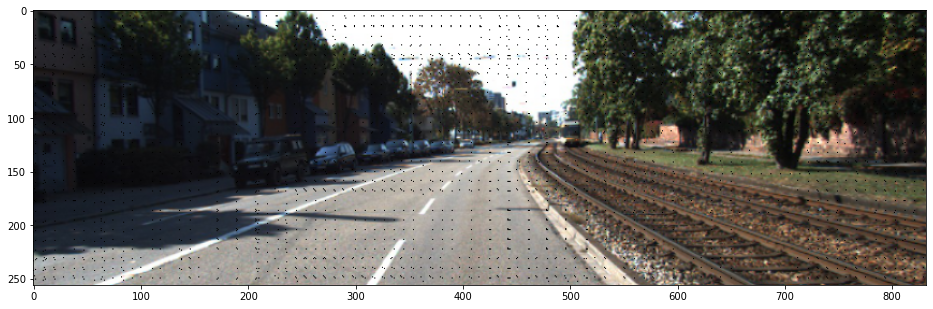

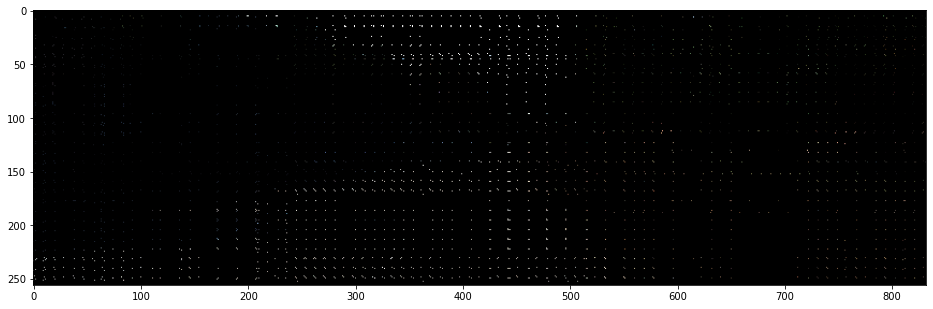

In [87]:
from utils.inverse_warp import pose_vec2mat
from utils.sceneflow_util import pts2pixel_pose_ms, pixel2pts_ms, reconstructImg

img_l1 = data_dict['input_l1_aug']
img_r1 = data_dict['input_r1_aug']
img_l2 = data_dict['input_l2_aug'].squeeze().permute(1, 2, 0)
img_r2 = data_dict['input_r2_aug']
k_l1 = data_dict['input_k_l1_aug']
k_r1 = data_dict['input_k_r1_aug']

disp_l2 = torch.ones((1, 1, 256, 832)) * 0.1
pose_b = torch.tensor([[0.0, 0.0, 10.0, 0.0, 0.0, 0.0]])

pts2, k2_scale = pixel2pts_ms(k_l1.cuda(), disp_l2.cuda(), torch.tensor([[1.0, 1.0]]).cuda())
pts2_tf, coord2 = pts2pixel_pose_ms(k_l1.cuda(), pts2.cuda(), pose_b.cuda(), [256, 832])

img_l1_warp_2 = reconstructImg(coord2, img_l1.cuda()).cpu().squeeze().permute(1, 2, 0)

plt.figure(figsize=(16, 16))
plt.imshow(img_l1_warp_2)
plt.show()

plt.figure(figsize=(16, 16))
plt.imshow(img_l1_warp_1 - img_l1_warp_2)
plt.show()

In [74]:
for epoch in range(30):
    loss_dict_avg, output_dict, data = train_one_epoch(args, model, loss, train_loader, optimizer, augmentations, None)
    print(loss_dict_avg['sf'], loss_dict_avg['dp'])

tensor(25.6850, device='cuda:0', grad_fn=<DivBackward0>) tensor(6.9832, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25.3768, device='cuda:0', grad_fn=<DivBackward0>) tensor(6.9857, device='cuda:0', grad_fn=<DivBackward0>)
tensor(25.0464, device='cuda:0', grad_fn=<DivBackward0>) tensor(6.9723, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24.8091, device='cuda:0', grad_fn=<DivBackward0>) tensor(6.9692, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24.6122, device='cuda:0', grad_fn=<DivBackward0>) tensor(6.9607, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24.3904, device='cuda:0', grad_fn=<DivBackward0>) tensor(6.9497, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24.1602, device='cuda:0', grad_fn=<DivBackward0>) tensor(6.9406, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23.9455, device='cuda:0', grad_fn=<DivBackward0>) tensor(6.9293, device='cuda:0', grad_fn=<DivBackward0>)


KeyboardInterrupt: 

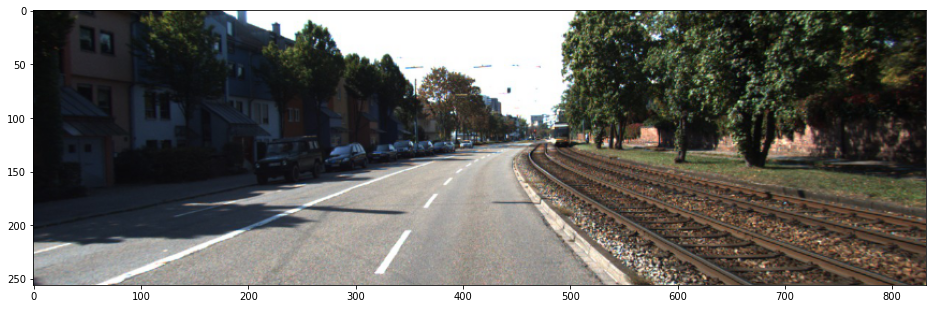

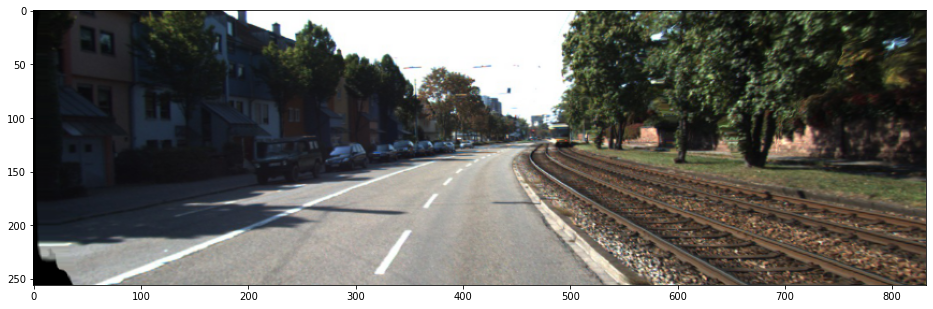

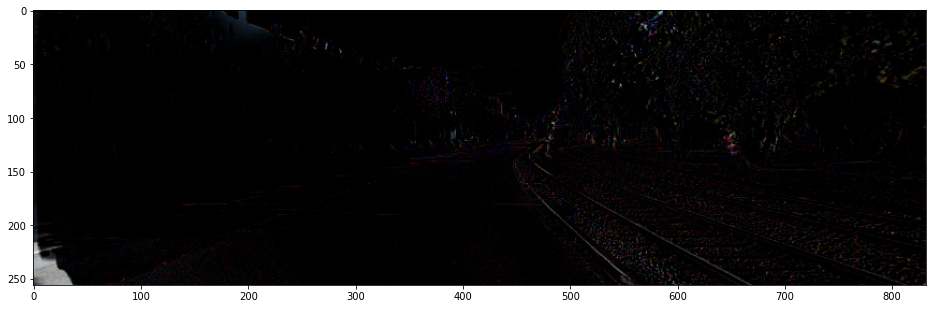

In [20]:
from losses import _generate_image_left
import matplotlib.pyplot as plt
from utils.sceneflow_util import pts2pixel_ms, pixel2pts_ms


img_l1 = data['input_l1_aug'].cpu().detach()
img_r1 = data['input_r1_aug'].cpu().detach()
img_l2 = data['input_l2_aug'].cpu().detach()
k_l1 = data['input_k_l1_aug'].cpu().detach()

disp_l1 = output_dict['disp_l1'][0].cpu().detach()
img_r1_warp = _generate_image_left(img=img_r1, disp=disp_l1)

plt.figure(figsize=(16, 16))
plt.imshow(img_l1.squeeze().permute(1, 2, 0).numpy())
plt.show()
plt.figure(figsize=(16, 16))
plt.imshow(img_r1_warp.squeeze().permute(1, 2, 0).numpy())
plt.show()
plt.figure(figsize=(16, 16))
plt.imshow(img_l1.squeeze().permute(1, 2, 0).numpy() - img_r1_warp.squeeze().permute(1, 2, 0).numpy())
plt.show()